In [1]:
import numpy as np
import pandas as pd
import tqdm

In [2]:
data_dir = '/home/vadim/playlist_generation/data/random_data'

### Загружаем mpd_data(Million playlist dataset)

In [3]:
mpd_data = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
mpd_data.head()

,pid,trackid
21114,822314,1149
21117,822314,230
21119,822314,4937
40467,822595,23973
40473,822595,4171


### Определяем рейтинг единичкой

In [4]:
mpd_data['rating'] = 1
mpd_data.head()

,pid,trackid,rating
21114,822314,1149,1
21117,822314,230,1
21119,822314,4937,1
40467,822595,23973,1
40473,822595,4171,1


### Обрежем mpd_data по пользователям для быстроты

In [5]:
data = mpd_data

In [6]:
data.shape

(5732, 3)

In [7]:
from polara.recommender.data import RecommenderData
from polara.recommender.models import SVDModel
from sklearn.model_selection import KFold

In [8]:
def cross_validation_svd(data, n_splits=5, seed=1, test_size=0.05, topk=500, rank=10):
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        svd.switch_positive = 1
        svd.topk = topk
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')
        
        scores['precision'].append(relevance.precision)
        scores['recall'].append(relevance.recall)
        scores['miss_rate'].append(relevance.miss_rate)
        scores['nDCG'].append(ranking.nDCG)
        
    result = pd.DataFrame(scores)
    return result

In [11]:
topks = [500]
ranks = [3,4,5,10, 25, 50]
recall = []
nDCG = []
precision = []
miss_rate = []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    print(data.shape)
    result = cross_validation_svd(data, topk=500, test_size=0.1, rank=rank)
    recall.append(result.recall.mean())
    nDCG.append(result.nDCG.mean())
    precision.append(result.precision.mean())
    miss_rate.append(result.miss_rate.mean())

  0%|          | 0/6 [00:00<?, ?it/s]

             ===========rank=3=============
(5732, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.2974977680005395s
58 unique trackid's within 60 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
84 pid's were filtered out from testset. Reason: inconsistent with holdout.
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.0061247590001585195s
66 unique trackid's within 69 testset interactions were filtered. Reason: not in the training data.
8 unique trackid's within 8 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
81 pid's were filtered out from testset. Reason: inconsistent wit

 17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]

=========================Fold 5=============================
Preparing data...
Done.
PureSVD training time: 0.006025778000548598s
48 unique trackid's within 52 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
6 pid's were filtered out from holdout. Reason: inconsistent with testset.
74 pid's were filtered out from testset. Reason: inconsistent with holdout.
             ===========rank=4=============
(5732, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.0088859509996837s
58 unique trackid's within 60 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
84 pid's were filtered out from testset. Reason: inconsistent with

 33%|███▎      | 2/6 [00:01<00:02,  1.33it/s]

=========================Fold 5=============================
Preparing data...
Done.
PureSVD training time: 0.00795230900075694s
48 unique trackid's within 52 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
6 pid's were filtered out from holdout. Reason: inconsistent with testset.
74 pid's were filtered out from testset. Reason: inconsistent with holdout.
             ===========rank=5=============
(5732, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.007715256000665249s
58 unique trackid's within 60 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
84 pid's were filtered out from testset. Reason: inconsistent wit

 50%|█████     | 3/6 [00:02<00:02,  1.47it/s]

=========================Fold 5=============================
Preparing data...
Done.
PureSVD training time: 0.029588777000753907s
48 unique trackid's within 52 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
6 pid's were filtered out from holdout. Reason: inconsistent with testset.
74 pid's were filtered out from testset. Reason: inconsistent with holdout.
             ===========rank=10=============
(5732, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.013473652999891783s
58 unique trackid's within 60 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
84 pid's were filtered out from testset. Reason: inconsistent w

 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

=========================Fold 5=============================
Preparing data...
Done.
PureSVD training time: 0.02150497300135612s
48 unique trackid's within 52 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
6 pid's were filtered out from holdout. Reason: inconsistent with testset.
74 pid's were filtered out from testset. Reason: inconsistent with holdout.
             ===========rank=25=============
(5732, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.059446363999086316s
58 unique trackid's within 60 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
84 pid's were filtered out from testset. Reason: inconsistent wi

 83%|████████▎ | 5/6 [00:03<00:00,  1.38it/s]

=========================Fold 5=============================
Preparing data...
Done.
PureSVD training time: 0.035318272000949946s
48 unique trackid's within 52 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
6 pid's were filtered out from holdout. Reason: inconsistent with testset.
74 pid's were filtered out from testset. Reason: inconsistent with holdout.
             ===========rank=50=============
(5732, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.10737475300084043s
58 unique trackid's within 60 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
84 pid's were filtered out from testset. Reason: inconsistent wi

100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

PureSVD training time: 0.20468552199963597s
48 unique trackid's within 52 testset interactions were filtered. Reason: not in the training data.
2 unique trackid's within 2 holdout interactions were filtered. Reason: not in the training data.
6 pid's were filtered out from holdout. Reason: inconsistent with testset.
74 pid's were filtered out from testset. Reason: inconsistent with holdout.


In [9]:
import matplotlib.pyplot as plt

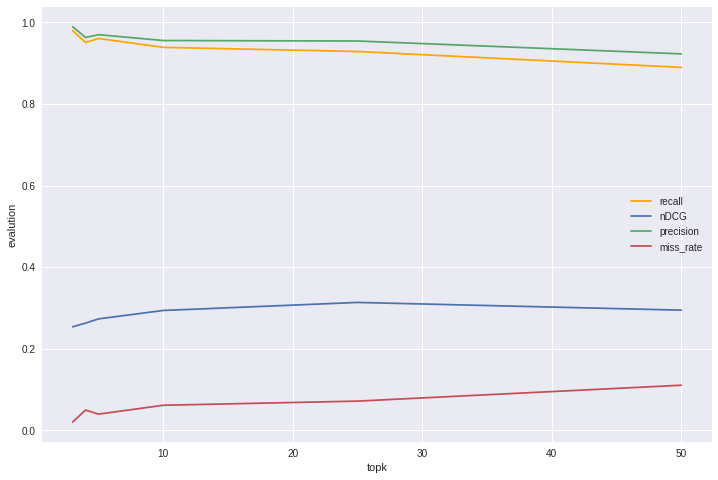

In [12]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall, 'orange', label='recall')
plt.plot(ranks, nDCG,label='nDCG')
plt.plot(ranks, precision, label='precision')
plt.plot(ranks, miss_rate, label='miss_rate')
plt.ylabel('evalution')
plt.xlabel('topk')
plt.legend()
plt.show()